<a href="https://colab.research.google.com/github/liam-sbhoo/TabPFN-TS/blob/main/Time%20Series%20Forecasting%20with%20TabPFN-TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with TabPFN-TS

## Setting up the environment

In [ ]:
!pip install tabpfn-client
!pip install datasets           # for huggingface dataset download
!pip install gluonts            # for timestamps feature extraction


  Using cached datasets-3.0.0-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
Using cached datasets-3.0.0-py3-none-any.whl (474 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

You'll have to first register for an account/login to an existing account.

In [ ]:
from tabpfn_client import init

init()

### Helper Functions

#### Data Type and Manipulation

##### TimeSeriesDataFrame

Adapted from AutoGluon

https://github.com/autogluon/autogluon/blob/master/timeseries/src/autogluon/timeseries/dataset/ts_dataframe.py

In [ ]:
from __future__ import annotations

import copy
import itertools
import logging
import reprlib
from collections.abc import Iterable
from itertools import islice
from pathlib import Path
from typing import Any, List, Optional, Tuple, Type, Union

import datasets
import pandas as pd
from joblib.parallel import Parallel, delayed
from pandas.core.internals import ArrayManager, BlockManager


ITEMID = "item_id"
TIMESTAMP = "timestamp"

IRREGULAR_TIME_INDEX_FREQSTR = "IRREG"


class TimeSeriesDataFrame(pd.DataFrame):
    """A collection of univariate time series, where each row is identified by an (``item_id``, ``timestamp``) pair.

    For example, a time series data frame could represent the daily sales of a collection of products, where each
    ``item_id`` corresponds to a product and ``timestamp`` corresponds to the day of the record.

    Parameters
    ----------
    data : pd.DataFrame, str, pathlib.Path or Iterable
        Time series data to construct a ``TimeSeriesDataFrame``. The class currently supports four input formats.

        1. Time series data in a pandas DataFrame format without multi-index. For example::

                   item_id  timestamp  target
                0        0 2019-01-01       0
                1        0 2019-01-02       1
                2        0 2019-01-03       2
                3        1 2019-01-01       3
                4        1 2019-01-02       4
                5        1 2019-01-03       5
                6        2 2019-01-01       6
                7        2 2019-01-02       7
                8        2 2019-01-03       8

        You can also use :meth:`~autogluon.timeseries.TimeSeriesDataFrame.from_data_frame` for loading data in such format.

        2. Path to a data file in CSV or Parquet format. The file must contain columns ``item_id`` and ``timestamp``, as well as columns with time series values. This is similar to Option 1 above (pandas DataFrame format without multi-index). Both remote (e.g., S3) and local paths are accepted. You can also use :meth:`~autogluon.timeseries.TimeSeriesDataFrame.from_path` for loading data in such format.

        3. Time series data in pandas DataFrame format with multi-index on ``item_id`` and ``timestamp``. For example::

                                    target
                item_id timestamp
                0       2019-01-01       0
                        2019-01-02       1
                        2019-01-03       2
                1       2019-01-01       3
                        2019-01-02       4
                        2019-01-03       5
                2       2019-01-01       6
                        2019-01-02       7
                        2019-01-03       8

        4. Time series data in Iterable format. For example::

                iterable_dataset = [
                    {"target": [0, 1, 2], "start": pd.Period("01-01-2019", freq='D')},
                    {"target": [3, 4, 5], "start": pd.Period("01-01-2019", freq='D')},
                    {"target": [6, 7, 8], "start": pd.Period("01-01-2019", freq='D')}
                ]

        You can also use :meth:`~autogluon.timeseries.TimeSeriesDataFrame.from_iterable_dataset` for loading data in such format.

    static_features : pd.DataFrame, str or pathlib.Path, optional
        An optional data frame describing the metadata of each individual time series that does not change with time.
        Can take real-valued or categorical values. For example, if ``TimeSeriesDataFrame`` contains sales of various
        products, static features may refer to time-independent features like color or brand.

        The index of the ``static_features`` index must contain a single entry for each item present in the respective
        ``TimeSeriesDataFrame``. For example, the following ``TimeSeriesDataFrame``::

                                target
            item_id timestamp
            A       2019-01-01       0
                    2019-01-02       1
                    2019-01-03       2
            B       2019-01-01       3
                    2019-01-02       4
                    2019-01-03       5

        is compatible with the following ``static_features``::

                     feat_1 feat_2
            item_id
            A           2.0    bar
            B           5.0    foo

        ``TimeSeriesDataFrame`` will ensure consistency of static features during serialization/deserialization, copy
        and slice operations.

        If ``static_features`` are provided during ``fit``, the ``TimeSeriesPredictor`` expects the same metadata to be
        available during prediction time.
    id_column : str, optional
        Name of the ``item_id`` column, if it's different from the default. This argument is only used when
        constructing a TimeSeriesDataFrame using format 1 (DataFrame without multi-index) or 2 (path to a file).
    timestamp_column : str, optional
        Name of the ``timestamp`` column, if it's different from the default. This argument is only used when
        constructing a TimeSeriesDataFrame using format 1 (DataFrame without multi-index) or 2 (path to a file).
    num_cpus : int, default = -1
        Number of CPU cores used to process the iterable dataset in parallel. Set to -1 to use all cores. This argument
        is only used when constructing a TimeSeriesDataFrame using format 4 (iterable dataset).

    Attributes
    ----------
    freq : str
        A pandas-compatible string describing the frequency of the time series. For example ``"D"`` for daily data,
        ``"h"`` for hourly data, etc. This attribute is determined automatically based on the timestamps. For the full
        list of possible values, see `pandas documentation <https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases>`_.
    num_items : int
        Number of items (time series) in the data set.
    item_ids : pd.Index
        List of unique time series IDs contained in the data set.
    """

    index: pd.MultiIndex
    _metadata = ["_static_features", "_cached_freq"]

    def __init__(
        self,
        data: Union[pd.DataFrame, str, Path, Iterable],
        static_features: Optional[Union[pd.DataFrame, str, Path]] = None,
        id_column: Optional[str] = None,
        timestamp_column: Optional[str] = None,
        num_cpus: int = -1,
        *args,
        **kwargs,
    ):
        if isinstance(data, (BlockManager, ArrayManager)):
            # necessary for copy constructor to work in pandas <= 2.0.x. In >= 2.1.x this is replaced by _constructor_from_mgr
            pass
        elif isinstance(data, pd.DataFrame):
            if isinstance(data.index, pd.MultiIndex):
                self._validate_multi_index_data_frame(data)
            else:
                data = self._construct_tsdf_from_data_frame(
                    data, id_column=id_column, timestamp_column=timestamp_column
                )
        elif isinstance(data, (str, Path)):
            raise NotImplementedError
            # data = self._construct_tsdf_from_data_frame(
            #     load_pd.load(str(data)), id_column=id_column, timestamp_column=timestamp_column
            # )
        elif isinstance(data, Iterable):
            data = self._construct_tsdf_from_iterable_dataset(data, num_cpus=num_cpus)
        else:
            raise ValueError(
                f"data must be a pd.DataFrame, Iterable, string or Path (received {type(data)})."
            )
        super().__init__(data=data, *args, **kwargs)
        self._static_features: Optional[pd.DataFrame] = None
        if static_features is not None:
            self.static_features = self._construct_static_features(
                static_features, id_column=id_column
            )

        # internal value for cached frequency values that are inferred. corresponds to either a
        # pandas-compatible frequency string, the value IRREGULAR_TIME_INDEX_FREQSTR that signals
        # the time series have irregular timestamps (in which case tsdf.freq returns None), or None
        # if inference was not yet performed.
        self._cached_freq: Optional[str] = None

    @property
    def _constructor(self) -> Type[TimeSeriesDataFrame]:
        return TimeSeriesDataFrame

    def _constructor_from_mgr(self, mgr, axes):
        # Use the default constructor when constructing from _mgr. Otherwise pandas enters an infinite recursion by
        # repeatedly calling TimeSeriesDataFrame constructor
        df = self._from_mgr(mgr, axes=axes)
        df._static_features = self._static_features
        df._cached_freq = self._cached_freq
        return df

    @classmethod
    def _construct_tsdf_from_data_frame(
        cls,
        df: pd.DataFrame,
        id_column: Optional[str] = None,
        timestamp_column: Optional[str] = None,
    ) -> pd.DataFrame:
        df = df.copy()
        if id_column is not None:
            assert id_column in df.columns, f"Column '{id_column}' not found!"
            if id_column != ITEMID and ITEMID in df.columns:
                logger.warning(
                    f"Renaming existing column '{ITEMID}' -> '__{ITEMID}' to avoid name collisions."
                )
                df.rename(columns={ITEMID: "__" + ITEMID}, inplace=True)
            df.rename(columns={id_column: ITEMID}, inplace=True)

        if timestamp_column is not None:
            assert (
                timestamp_column in df.columns
            ), f"Column '{timestamp_column}' not found!"
            if timestamp_column != TIMESTAMP and TIMESTAMP in df.columns:
                logger.warning(
                    f"Renaming existing column '{TIMESTAMP}' -> '__{TIMESTAMP}' to avoid name collisions."
                )
                df.rename(columns={TIMESTAMP: "__" + TIMESTAMP}, inplace=True)
            df.rename(columns={timestamp_column: TIMESTAMP}, inplace=True)

        if TIMESTAMP in df.columns:
            df[TIMESTAMP] = pd.to_datetime(df[TIMESTAMP])

        cls._validate_data_frame(df)
        return df.set_index([ITEMID, TIMESTAMP])

    @classmethod
    def _construct_tsdf_from_iterable_dataset(
        cls, iterable_dataset: Iterable, num_cpus: int = -1
    ) -> pd.DataFrame:
        def load_single_item(item_id: int, ts: dict) -> pd.DataFrame:
            start_timestamp = ts["start"]
            freq = start_timestamp.freq
            if isinstance(start_timestamp, pd.Period):
                start_timestamp = start_timestamp.to_timestamp(how="S")
            target = ts["target"]
            datetime_index = tuple(
                pd.date_range(start_timestamp, periods=len(target), freq=freq)
            )
            idx = pd.MultiIndex.from_product(
                [(item_id,), datetime_index], names=[ITEMID, TIMESTAMP]
            )
            return pd.Series(target, name="target", index=idx).to_frame()

        cls._validate_iterable(iterable_dataset)
        all_ts = Parallel(n_jobs=num_cpus)(
            delayed(load_single_item)(item_id, ts)
            for item_id, ts in enumerate(iterable_dataset)
        )
        return pd.concat(all_ts)

    @classmethod
    def _validate_multi_index_data_frame(cls, data: pd.DataFrame):
        """Validate a multi-index pd.DataFrame can be converted to TimeSeriesDataFrame"""

        if not isinstance(data, pd.DataFrame):
            raise ValueError(f"data must be a pd.DataFrame, got {type(data)}")
        if not isinstance(data.index, pd.MultiIndex):
            raise ValueError(f"data must have pd.MultiIndex, got {type(data.index)}")
        if not pd.api.types.is_datetime64_dtype(data.index.dtypes[TIMESTAMP]):
            raise ValueError(
                f"for {TIMESTAMP}, the only pandas dtype allowed is `datetime64`."
            )
        if not data.index.names == (f"{ITEMID}", f"{TIMESTAMP}"):
            raise ValueError(
                f"data must have index names as ('{ITEMID}', '{TIMESTAMP}'), got {data.index.names}"
            )
        item_id_index = data.index.get_level_values(level=ITEMID)
        if not (
            pd.api.types.is_integer_dtype(item_id_index)
            or pd.api.types.is_string_dtype(item_id_index)
        ):
            raise ValueError(
                f"all entries in index `{ITEMID}` must be of integer or string dtype"
            )

    @classmethod
    def _validate_data_frame(cls, df: pd.DataFrame):
        """Validate that a pd.DataFrame with ITEMID and TIMESTAMP columns can be converted to TimeSeriesDataFrame"""
        if not isinstance(df, pd.DataFrame):
            raise ValueError(f"data must be a pd.DataFrame, got {type(df)}")
        if ITEMID not in df.columns:
            raise ValueError(f"data must have a `{ITEMID}` column")
        if TIMESTAMP not in df.columns:
            raise ValueError(f"data must have a `{TIMESTAMP}` column")
        if df[ITEMID].isnull().any():
            raise ValueError(f"`{ITEMID}` column can not have nan")
        if df[TIMESTAMP].isnull().any():
            raise ValueError(f"`{TIMESTAMP}` column can not have nan")
        if not pd.api.types.is_datetime64_dtype(df[TIMESTAMP]):
            raise ValueError(
                f"for {TIMESTAMP}, the only pandas dtype allowed is `datetime64`."
            )
        item_id_column = df[ITEMID]
        if not (
            pd.api.types.is_integer_dtype(item_id_column)
            or pd.api.types.is_string_dtype(item_id_column)
        ):
            raise ValueError(
                f"all entries in column `{ITEMID}` must be of integer or string dtype"
            )

    @classmethod
    def _validate_iterable(cls, data: Iterable):
        if not isinstance(data, Iterable):
            raise ValueError("data must be of type Iterable.")

        first = next(iter(data), None)
        if first is None:
            raise ValueError("data has no time-series.")

        for i, ts in enumerate(itertools.chain([first], data)):
            if not isinstance(ts, dict):
                raise ValueError(
                    f"{i}'th time-series in data must be a dict, got{type(ts)}"
                )
            if not ("target" in ts and "start" in ts):
                raise ValueError(
                    f"{i}'th time-series in data must have 'target' and 'start', got{ts.keys()}"
                )
            if not isinstance(ts["start"], pd.Period):
                raise ValueError(
                    f"{i}'th time-series must have a pandas Period as 'start', got {ts['start']}"
                )

    @classmethod
    def from_data_frame(
        cls,
        df: pd.DataFrame,
        id_column: Optional[str] = None,
        timestamp_column: Optional[str] = None,
        static_features_df: Optional[pd.DataFrame] = None,
    ) -> TimeSeriesDataFrame:
        """Construct a ``TimeSeriesDataFrame`` from a pandas DataFrame.

        Parameters
        ----------
        df : pd.DataFrame
            A pd.DataFrame with 'item_id' and 'timestamp' as columns. For example::

                   item_id  timestamp  target
                0        0 2019-01-01       0
                1        0 2019-01-02       1
                2        0 2019-01-03       2
                3        1 2019-01-01       3
                4        1 2019-01-02       4
                5        1 2019-01-03       5
                6        2 2019-01-01       6
                7        2 2019-01-02       7
                8        2 2019-01-03       8
        id_column : str, optional
            Name of the 'item_id' column if column name is different
        timestamp_column : str, optional
            Name of the 'timestamp' column if column name is different
        static_features_df : pd.DataFrame, optional
            A pd.DataFrame with 'item_id' column that contains the static features for each time series. For example::

                   item_id feat_1   feat_2
                0        0 foo         0.5
                1        1 foo         2.2
                2        2 bar         0.1

        Returns
        -------
        ts_df: TimeSeriesDataFrame
            A data frame in TimeSeriesDataFrame format.
        """
        return cls(
            df,
            static_features=static_features_df,
            id_column=id_column,
            timestamp_column=timestamp_column,
        )

    @classmethod
    def from_path(
        cls,
        path: Union[str, Path],
        id_column: Optional[str] = None,
        timestamp_column: Optional[str] = None,
        static_features_path: Optional[Union[str, Path]] = None,
    ) -> TimeSeriesDataFrame:
        """Construct a ``TimeSeriesDataFrame`` from a CSV or Parquet file.

        Parameters
        ----------
        path : str or pathlib.Path
            Path to a local or remote (e.g., S3) file containing the time series data in CSV or Parquet format.
            Example file contents::

                item_id,timestamp,target
                0,2019-01-01,0
                0,2019-01-02,1
                0,2019-01-03,2
                1,2019-01-01,3
                1,2019-01-02,4
                1,2019-01-03,5
                2,2019-01-01,6
                2,2019-01-02,7
                2,2019-01-03,8

        id_column : str, optional
            Name of the 'item_id' column if column name is different
        timestamp_column : str, optional
            Name of the 'timestamp' column if column name is different
        static_features_path : str or pathlib.Path, optional
            Path to a local or remote (e.g., S3) file containing static features in CSV or Parquet format.
            Example file contents::

                item_id,feat_1,feat_2
                0,foo,0.5
                1,foo,2.2
                2,bar,0.1

        Returns
        -------
        ts_df: TimeSeriesDataFrame
            A data frame in TimeSeriesDataFrame format.
        """
        return cls(
            path,
            static_features=static_features_path,
            id_column=id_column,
            timestamp_column=timestamp_column,
        )

    @classmethod
    def from_iterable_dataset(
        cls, iterable_dataset: Iterable, num_cpus: int = -1
    ) -> TimeSeriesDataFrame:
        """Construct a ``TimeSeriesDataFrame`` from an Iterable of dictionaries each of which
        represent a single time series.

        This function also offers compatibility with GluonTS `ListDataset format <https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.common.html#gluonts.dataset.common.ListDataset>`_.

        Parameters
        ----------
        iterable_dataset: Iterable
            An iterator over dictionaries, each with a ``target`` field specifying the value of the
            (univariate) time series, and a ``start`` field with the starting time as a pandas Period .
            Example::

                iterable_dataset = [
                    {"target": [0, 1, 2], "start": pd.Period("01-01-2019", freq='D')},
                    {"target": [3, 4, 5], "start": pd.Period("01-01-2019", freq='D')},
                    {"target": [6, 7, 8], "start": pd.Period("01-01-2019", freq='D')}
                ]
        num_cpus : int, default = -1
            Number of CPU cores used to process the iterable dataset in parallel. Set to -1 to use all cores.

        Returns
        -------
        ts_df: TimeSeriesDataFrame
            A data frame in TimeSeriesDataFrame format.
        """
        return cls(iterable_dataset, num_cpus=num_cpus)

    @property
    def item_ids(self) -> pd.Index:
        return self.index.unique(level=ITEMID)

    @property
    def static_features(self):
        return self._static_features

    def _construct_static_features(
        cls,
        static_features: Union[pd.DataFrame, str, Path],
        id_column: Optional[str] = None,
    ) -> pd.DataFrame:
        if isinstance(static_features, (str, Path)):
            raise NotImplementedError("Loading from path is not implemented yet")
            # static_features = load_pd.load(str(static_features))
        if not isinstance(static_features, pd.DataFrame):
            raise ValueError(
                f"static_features must be a pd.DataFrame, string or Path (received {type(static_features)})"
            )

        if id_column is not None:
            assert (
                id_column in static_features.columns
            ), f"Column '{id_column}' not found in static_features!"
            if id_column != ITEMID and ITEMID in static_features.columns:
                logger.warning(
                    f"Renaming existing column '{ITEMID}' -> '__{ITEMID}' to avoid name collisions."
                )
                static_features.rename(columns={ITEMID: "__" + ITEMID}, inplace=True)
            static_features.rename(columns={id_column: ITEMID}, inplace=True)
        return static_features

    @static_features.setter
    def static_features(self, value: Optional[pd.DataFrame]):
        # if the current item index is not a multiindex, then we are dealing with a single
        # item slice. this should only happen when the user explicitly requests only a
        # single item or during `slice_by_timestep`. In this case we do not set static features
        if not isinstance(self.index, pd.MultiIndex):
            return

        if value is not None:
            if isinstance(value, pd.Series):
                value = value.to_frame()
            if not isinstance(value, pd.DataFrame):
                raise ValueError(
                    f"static_features must be a pandas DataFrame (received object of type {type(value)})"
                )
            if isinstance(value.index, pd.MultiIndex):
                raise ValueError("static_features cannot have a MultiIndex")

            # Avoid modifying static features inplace
            value = value.copy()
            if ITEMID in value.columns and value.index.name != ITEMID:
                value = value.set_index(ITEMID)
            if value.index.name != ITEMID:
                value.index.rename(ITEMID, inplace=True)
            missing_item_ids = self.item_ids.difference(value.index)
            if len(missing_item_ids) > 0:
                raise ValueError(
                    "Following item_ids are missing from the index of static_features: "
                    f"{reprlib.repr(missing_item_ids.to_list())}"
                )
            # if provided static features are a strict superset of the item index, we take a subset to ensure consistency
            if len(value.index.difference(self.item_ids)) > 0:
                value = value.reindex(self.item_ids)

        self._static_features = value

    @property
    def freq(self):
        if (
            self._cached_freq is not None
            and self._cached_freq == IRREGULAR_TIME_INDEX_FREQSTR
        ):
            return None  # irregularly sampled time series
        elif self._cached_freq:
            return self._cached_freq

        def get_freq(series):
            return series.index.freq or series.index.inferred_freq

        # check the frequencies of the first 100 items to see if frequencies are consistent and
        # can be inferred
        freq_for_each_series = [get_freq(self.loc[idx]) for idx in self.item_ids[:100]]
        freq = freq_for_each_series[0]
        if len(set(freq_for_each_series)) > 1 or freq is None:
            self._cached_freq = IRREGULAR_TIME_INDEX_FREQSTR
            return None

        freq = freq.freqstr if isinstance(freq, pd._libs.tslibs.BaseOffset) else freq
        self._cached_freq = freq
        return freq

    @property
    def num_items(self):
        return len(self.item_ids)

    def num_timesteps_per_item(self) -> pd.Series:
        """Length of each time series in the dataframe."""
        return self.groupby(level=ITEMID, sort=False).size()

    def copy(self: TimeSeriesDataFrame, deep: bool = True) -> pd.DataFrame:  # noqa
        """Make a copy of the TimeSeriesDataFrame.

        When ``deep=True`` (default), a new object will be created with a copy of the calling object's data and
        indices. Modifications to the data or indices of the copy will not be reflected in the original object.

        When ``deep=False``, a new object will be created without copying the calling object's data or index (only
        references to the data and index are copied). Any changes to the data of the original will be reflected in the
        shallow copy (and vice versa).

        For more details, see `pandas documentation <https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html>`_.
        """
        obj = super().copy(deep=deep)

        # also perform a deep copy for static features
        if deep:
            for k in obj._metadata:
                setattr(obj, k, copy.deepcopy(getattr(obj, k)))
        return obj

    def __finalize__(  # noqa
        self: TimeSeriesDataFrame, other, method: Optional[str] = None, **kwargs
    ) -> TimeSeriesDataFrame:
        super().__finalize__(other=other, method=method, **kwargs)
        # when finalizing the copy/slice operation, we use the property setter to stay consistent
        # with the item index
        if hasattr(other, "_static_features"):
            self.static_features = other._static_features
        if hasattr(other, "_cached_freq"):
            self._cached_freq = other._cached_freq
        return self

    def split_by_time(
        self, cutoff_time: pd.Timestamp
    ) -> Tuple[TimeSeriesDataFrame, TimeSeriesDataFrame]:
        """Split dataframe to two different ``TimeSeriesDataFrame`` s before and after a certain ``cutoff_time``.

        Parameters
        ----------
        cutoff_time: pd.Timestamp
            The time to split the current data frame into two data frames.

        Returns
        -------
        data_before: TimeSeriesDataFrame
            Data frame containing time series before the ``cutoff_time`` (exclude ``cutoff_time``).
        data_after: TimeSeriesDataFrame
            Data frame containing time series after the ``cutoff_time`` (include ``cutoff_time``).
        """

        nanosecond_before_cutoff = cutoff_time - pd.Timedelta(nanoseconds=1)
        data_before = self.loc[(slice(None), slice(None, nanosecond_before_cutoff)), :]
        data_after = self.loc[(slice(None), slice(cutoff_time, None)), :]
        before = TimeSeriesDataFrame(data_before, static_features=self.static_features)
        after = TimeSeriesDataFrame(data_after, static_features=self.static_features)
        before._cached_freq = self._cached_freq
        after._cached_freq = self._cached_freq
        return before, after

    def slice_by_timestep(
        self, start_index: Optional[int] = None, end_index: Optional[int] = None
    ) -> TimeSeriesDataFrame:
        """Select a subsequence from each time series between start (inclusive) and end (exclusive) indices.

        This operation is equivalent to selecting a slice ``[start_index : end_index]`` from each time series, and then
        combining these slices into a new ``TimeSeriesDataFrame``. See examples below.

        Returns a copy of the original data. This is useful for constructing holdout sets for validation.

        Parameters
        ----------
        start_index : int or None
            Start index (inclusive) of the slice for each time series.
            Negative values are counted from the end of each time series.
            When set to None, the slice starts from the beginning of each time series.
        end_index : int or None
            End index (exclusive) of the slice for each time series.
            Negative values are counted from the end of each time series.
            When set to None, the slice includes the end of each time series.

        Returns
        -------
        ts_df : TimeSeriesDataFrame
            A new time series dataframe containing entries of the original time series between start and end indices.

        Examples
        --------
        >>> ts_df
                            target
        item_id timestamp
        0       2019-01-01       0
                2019-01-02       1
                2019-01-03       2
        1       2019-01-02       3
                2019-01-03       4
                2019-01-04       5
        2       2019-01-03       6
                2019-01-04       7
                2019-01-05       8

        Select the first entry of each time series

        >>> df.slice_by_timestep(0, 1)
                            target
        item_id timestamp
        0       2019-01-01       0
        1       2019-01-02       3
        2       2019-01-03       6

        Select the last 2 entries of each time series

        >>> df.slice_by_timestep(-2, None)
                            target
        item_id timestamp
        0       2019-01-02       1
                2019-01-03       2
        1       2019-01-03       4
                2019-01-04       5
        2       2019-01-04       7
                2019-01-05       8

        Select all except the last entry of each time series

        >>> df.slice_by_timestep(None, -1)
                            target
        item_id timestamp
        0       2019-01-01       0
                2019-01-02       1
        1       2019-01-02       3
                2019-01-03       4
        2       2019-01-03       6
                2019-01-04       7

        Copy the entire dataframe

        >>> df.slice_by_timestep(None, None)
                            target
        item_id timestamp
        0       2019-01-01       0
                2019-01-02       1
                2019-01-03       2
        1       2019-01-02       3
                2019-01-03       4
                2019-01-04       5
        2       2019-01-03       6
                2019-01-04       7
                2019-01-05       8

        """
        if start_index is not None and not isinstance(start_index, int):
            raise ValueError(
                f"start_index must be of type int or None (got {type(start_index)})"
            )
        if end_index is not None and not isinstance(end_index, int):
            raise ValueError(
                f"end_index must be of type int or None (got {type(end_index)})"
            )

        time_step_slice = slice(start_index, end_index)
        result = self.groupby(level=ITEMID, sort=False, as_index=False).nth(
            time_step_slice
        )
        result.static_features = self.static_features
        result._cached_freq = self._cached_freq
        return result

    def slice_by_time(
        self, start_time: pd.Timestamp, end_time: pd.Timestamp
    ) -> TimeSeriesDataFrame:
        """Select a subsequence from each time series between start (inclusive) and end (exclusive) timestamps.

        Parameters
        ----------
        start_time: pd.Timestamp
            Start time (inclusive) of the slice for each time series.
        end_time: pd.Timestamp
            End time (exclusive) of the slice for each time series.

        Returns
        -------
        ts_df : TimeSeriesDataFrame
            A new time series dataframe containing entries of the original time series between start and end timestamps.
        """

        if end_time < start_time:
            raise ValueError(
                f"end_time {end_time} is earlier than start_time {start_time}"
            )

        nanosecond_before_end_time = end_time - pd.Timedelta(nanoseconds=1)
        return TimeSeriesDataFrame(
            self.loc[(slice(None), slice(start_time, nanosecond_before_end_time)), :],
            static_features=self.static_features,
        )

    @classmethod
    def from_pickle(cls, filepath_or_buffer: Any) -> TimeSeriesDataFrame:
        """Convenience method to read pickled time series data frames. If the read pickle
        file refers to a plain pandas DataFrame, it will be cast to a TimeSeriesDataFrame.

        Parameters
        ----------
        filepath_or_buffer: Any
            Filename provided as a string or an ``IOBuffer`` containing the pickled object.

        Returns
        -------
        ts_df : TimeSeriesDataFrame
            The pickled time series data frame.
        """
        try:
            data = pd.read_pickle(filepath_or_buffer)
            return data if isinstance(data, cls) else cls(data)
        except Exception as err:  # noqa
            raise IOError(f"Could not load pickled data set due to error: {str(err)}")

    def fill_missing_values(
        self, method: str = "auto", value: float = 0.0
    ) -> TimeSeriesDataFrame:
        """Fill missing values represented by NaN.

        Parameters
        ----------
        method : str, default = "auto"
            Method used to impute missing values.

            - "auto" - first forward fill (to fill the in-between and trailing NaNs), then backward fill (to fill the leading NaNs)
            - "ffill" or "pad" - propagate last valid observation forward. Note: missing values at the start of the time series are not filled.
            - "bfill" or "backfill" - use next valid observation to fill gap. Note: this may result in information leakage; missing values at the end of the time series are not filled.
            - "constant" - replace NaNs with the given constant ``value``.
            - "interpolate" - fill NaN values using linear interpolation. Note: this may result in information leakage.
        value : float, default = 0.0
            Value used by the "constant" imputation method.

        Examples
        --------
        >>> ts_df
                            target
        item_id timestamp
        0       2019-01-01     NaN
                2019-01-02     NaN
                2019-01-03     1.0
                2019-01-04     NaN
                2019-01-05     NaN
                2019-01-06     2.0
                2019-01-07     NaN
        1       2019-02-04     NaN
                2019-02-05     3.0
                2019-02-06     NaN
                2019-02-07     4.0

        >>> ts_df.fill_missing_values(method="auto")
                            target
        item_id timestamp
        0       2019-01-01     1.0
                2019-01-02     1.0
                2019-01-03     1.0
                2019-01-04     1.0
                2019-01-05     1.0
                2019-01-06     2.0
                2019-01-07     2.0
        1       2019-02-04     3.0
                2019-02-05     3.0
                2019-02-06     3.0
                2019-02-07     4.0

        """
        # Convert to pd.DataFrame for faster processing
        df = pd.DataFrame(self)

        # Skip filling if there are no NaNs
        if not df.isna().any(axis=None):
            return self

        if not self.index.is_monotonic_increasing:
            logger.warning(
                "Trying to fill missing values in an unsorted dataframe. "
                "It is highly recommended to call `ts_df.sort_index()` before calling `ts_df.fill_missing_values()`"
            )

        grouped_df = df.groupby(level=ITEMID, sort=False, group_keys=False)
        if method == "auto":
            filled_df = grouped_df.ffill()
            # If necessary, fill missing values at the start of each time series with bfill
            if filled_df.isna().any(axis=None):
                filled_df = filled_df.groupby(
                    level=ITEMID, sort=False, group_keys=False
                ).bfill()
        elif method in ["ffill", "pad"]:
            filled_df = grouped_df.ffill()
        elif method in ["bfill", "backfill"]:
            filled_df = grouped_df.bfill()
        elif method == "constant":
            filled_df = self.fillna(value=value)
        elif method == "interpolate":
            filled_df = grouped_df.apply(lambda ts: ts.interpolate())
        else:
            raise ValueError(
                "Invalid fill method. Expecting one of "
                "{'auto', 'ffill', 'pad', 'bfill', 'backfill', 'constant', 'interpolate'}. "
                f"Got {method}"
            )
        return TimeSeriesDataFrame(filled_df, static_features=self.static_features)

    def dropna(self, how: str = "any") -> TimeSeriesDataFrame:
        """Drop rows containing NaNs.

        Parameters
        ----------
        how : {"any", "all"}, default = "any"
            Determine if row or column is removed from TimeSeriesDataFrame, when we have at least one NaN or all NaN.

            - "any" : If any NaN values are present, drop that row or column.
            - "all" : If all values are NaN, drop that row or column.
        """
        # We need to cast to a DataFrame first. Calling self.dropna() results in an exception because self.T
        # (used inside dropna) is not supported for TimeSeriesDataFrame
        dropped_df = pd.DataFrame(self).dropna(how=how)
        return TimeSeriesDataFrame(dropped_df, static_features=self.static_features)

    def get_model_inputs_for_scoring(
        self, prediction_length: int, known_covariates_names: Optional[List[str]] = None
    ) -> Tuple[TimeSeriesDataFrame, Optional[TimeSeriesDataFrame]]:
        """Prepare model inputs necessary to predict the last ``prediction_length`` time steps of each time series in the dataset.

        Parameters
        ----------
        prediction_length : int
            The forecast horizon, i.e., How many time steps into the future must be predicted.
        known_covariates_names : List[str], optional
            Names of the dataframe columns that contain covariates known in the future.
            See :attr:`known_covariates_names` of :class:`~autogluon.timeseries.TimeSeriesPredictor` for more details.

        Returns
        -------
        past_data : TimeSeriesDataFrame
            Data, where the last ``prediction_length`` time steps have been removed from the end of each time series.
        known_covariates : TimeSeriesDataFrame or None
            If ``known_covariates_names`` was provided, dataframe with the values of the known covariates during the
            forecast horizon. Otherwise, ``None``.
        """
        past_data = self.slice_by_timestep(None, -prediction_length)
        if known_covariates_names is not None and len(known_covariates_names) > 0:
            future_data = self.slice_by_timestep(-prediction_length, None)
            known_covariates = future_data[known_covariates_names]
        else:
            known_covariates = None
        return past_data, known_covariates

    def train_test_split(
        self,
        prediction_length: int,
        end_index: Optional[int] = None,
        suffix: Optional[str] = None,
    ) -> Tuple[TimeSeriesDataFrame, TimeSeriesDataFrame]:
        """Generate a train/test split from the given dataset.
        This method can be used to generate splits for multi-window backtesting.

        Parameters
        ----------
        prediction_length : int
            Number of time steps in a single evaluation window.
        end_index : int, optional
            If given, all time series will be shortened up to ``end_idx`` before the train/test splitting. In other
            words, test data will include the slice ``[:end_index]`` of each time series, and train data will include
            the slice ``[:end_index - prediction_length]``.
        suffix : str, optional
            Suffix appended to all entries in the ``item_id`` index level.

        Returns
        -------
        train_data : TimeSeriesDataFrame
            Train portion of the data. Contains the slice ``[:-prediction_length]`` of each time series in ``test_data``.
        test_data : TimeSeriesDataFrame
            Test portion of the data. Contains the slice ``[:end_idx]`` of each time series in the original dataset.
        """
        test_data = self.slice_by_timestep(None, end_index)
        train_data = test_data.slice_by_timestep(None, -prediction_length)

        if suffix is not None:
            for data in [train_data, test_data]:
                new_item_id = data.index.levels[0].astype(str) + suffix
                data.index = data.index.set_levels(levels=new_item_id, level=0)
                if data.static_features is not None:
                    data.static_features.index = data.static_features.index.astype(str)
                    data.static_features.index += suffix
        return train_data, test_data

    def convert_frequency(
        self,
        freq: Union[str, pd.DateOffset],
        agg_numeric: str = "mean",
        agg_categorical: str = "first",
        num_cpus: int = -1,
        chunk_size: int = 100,
        **kwargs,
    ) -> TimeSeriesDataFrame:
        """Convert each time series in the data frame to the given frequency.

        This method is useful for two purposes:

        1. Converting an irregularly-sampled time series to a regular time index.
        2. Aggregating time series data by downsampling (e.g., convert daily sales into weekly sales)

        Standard ``df.groupby(...).resample(...)`` can be extremely slow for large datasets, so we parallelize this
        operation across multiple CPU cores.


        Parameters
        ----------
        freq : Union[str, pd.DateOffset]
            Frequency to which the data should be converted. See `pandas frequency aliases <https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases>`_
            for supported values.
        agg_numeric : {"max", "min", "sum", "mean", "median", "first", "last"}, default = "mean"
            Aggregation method applied to numeric columns.
        agg_categorical : {"first", "last"}, default = "first"
            Aggregation method applied to categorical columns.
        num_cpus : int, default = -1
            Number of CPU cores used when resampling in parallel. Set to -1 to use all cores.
        chunk_size : int, default = 100
            Number of time series in a chunk assigned to each parallel worker.
        **kwargs
            Additional keywords arguments that will be passed to ``pandas.DataFrameGroupBy.resample``.

        Returns
        -------
        ts_df : TimeSeriesDataFrame
            A new time series dataframe with time series resampled at the new frequency. Output may contain missing
            values represented by ``NaN`` if original data does not have information for the given period.

        Examples
        --------
        Convert irregularly-sampled time series data to a regular index

        >>> ts_df
                            target
        item_id timestamp
        0       2019-01-01     NaN
                2019-01-03     1.0
                2019-01-06     2.0
                2019-01-07     NaN
        1       2019-02-04     3.0
                2019-02-07     4.0
        >>> ts_df.convert_frequency(freq="D")
                            target
        item_id timestamp
        0       2019-01-01     NaN
                2019-01-02     NaN
                2019-01-03     1.0
                2019-01-04     NaN
                2019-01-05     NaN
                2019-01-06     2.0
                2019-01-07     NaN
        1       2019-02-04     3.0
                2019-02-05     NaN
                2019-02-06     NaN
                2019-02-07     4.0

        Downsample quarterly data to yearly frequency

        >>> ts_df
                            target
        item_id timestamp
        0       2020-03-31     1.0
                2020-06-30     2.0
                2020-09-30     3.0
                2020-12-31     4.0
                2021-03-31     5.0
                2021-06-30     6.0
                2021-09-30     7.0
                2021-12-31     8.0
        >>> ts_df.convert_frequency("YE")
                            target
        item_id timestamp
        0       2020-12-31     2.5
                2021-12-31     6.5
        >>> ts_df.convert_frequency("YE", agg_numeric="sum")
                            target
        item_id timestamp
        0       2020-12-31    10.0
                2021-12-31    26.0
        """
        offset = pd.tseries.frequencies.to_offset(freq)
        if self.freq == offset.freqstr:
            return self

        # We need to aggregate categorical columns separately because .agg("mean") deletes all non-numeric columns
        aggregation = {}
        for col in self.columns:
            if pd.api.types.is_numeric_dtype(self.dtypes[col]):
                aggregation[col] = agg_numeric
            else:
                aggregation[col] = agg_categorical

        def split_into_chunks(iterable: Iterable, size: int) -> Iterable[Iterable]:
            # Based on https://stackoverflow.com/a/22045226/5497447
            iterable = iter(iterable)
            return iter(lambda: tuple(islice(iterable, size)), ())

        def resample_chunk(chunk: Iterable[Tuple[str, pd.DataFrame]]) -> pd.DataFrame:
            resampled_dfs = []
            for item_id, df in chunk:
                resampled_df = df.resample(offset, level=TIMESTAMP, **kwargs).agg(
                    aggregation
                )
                resampled_dfs.append(pd.concat({item_id: resampled_df}, names=[ITEMID]))
            return pd.concat(resampled_dfs)

        # Resampling time for 1 item < overhead time for a single parallel job. Therefore, we group items into chunks
        # so that the speedup from parallelization isn't dominated by the communication costs.
        chunks = split_into_chunks(
            pd.DataFrame(self).groupby(level=ITEMID, sort=False), chunk_size
        )
        resampled_chunks = Parallel(n_jobs=num_cpus)(
            delayed(resample_chunk)(chunk) for chunk in chunks
        )
        resampled_df = TimeSeriesDataFrame(pd.concat(resampled_chunks))
        resampled_df.static_features = self.static_features
        return resampled_df

    def __dir__(self) -> List[str]:
        # This hides method from IPython autocomplete, but not VSCode autocomplete
        deprecated = ["get_reindexed_view", "to_regular_index"]
        return [d for d in super().__dir__() if d not in deprecated]

    def to_df(self) -> pd.DataFrame:
        return pd.DataFrame(self)




# Taken from pandas._libs.tslibs.dtypes.OFFSET_TO_PERIOD_FREQSTR
offset_alias_to_period_alias = {
    "WEEKDAY": "D",
    "EOM": "M",
    "BME": "M",
    "SME": "M",
    "BQS": "Q",
    "QS": "Q",
    "BQE": "Q",
    "BQE-DEC": "Q",
    "BQE-JAN": "Q",
    "BQE-FEB": "Q",
    "BQE-MAR": "Q",
    "BQE-APR": "Q",
    "BQE-MAY": "Q",
    "BQE-JUN": "Q",
    "BQE-JUL": "Q",
    "BQE-AUG": "Q",
    "BQE-SEP": "Q",
    "BQE-OCT": "Q",
    "BQE-NOV": "Q",
    "MS": "M",
    "D": "D",
    "B": "B",
    "min": "min",
    "s": "s",
    "ms": "ms",
    "us": "us",
    "ns": "ns",
    "h": "h",
    "QE": "Q",
    "QE-DEC": "Q-DEC",
    "QE-JAN": "Q-JAN",
    "QE-FEB": "Q-FEB",
    "QE-MAR": "Q-MAR",
    "QE-APR": "Q-APR",
    "QE-MAY": "Q-MAY",
    "QE-JUN": "Q-JUN",
    "QE-JUL": "Q-JUL",
    "QE-AUG": "Q-AUG",
    "QE-SEP": "Q-SEP",
    "QE-OCT": "Q-OCT",
    "QE-NOV": "Q-NOV",
    "YE": "Y",
    "YE-DEC": "Y-DEC",
    "YE-JAN": "Y-JAN",
    "YE-FEB": "Y-FEB",
    "YE-MAR": "Y-MAR",
    "YE-APR": "Y-APR",
    "YE-MAY": "Y-MAY",
    "YE-JUN": "Y-JUN",
    "YE-JUL": "Y-JUL",
    "YE-AUG": "Y-AUG",
    "YE-SEP": "Y-SEP",
    "YE-OCT": "Y-OCT",
    "YE-NOV": "Y-NOV",
    "W": "W",
    "ME": "M",
    "Y": "Y",
    "BYE": "Y",
    "BYE-DEC": "Y",
    "BYE-JAN": "Y",
    "BYE-FEB": "Y",
    "BYE-MAR": "Y",
    "BYE-APR": "Y",
    "BYE-MAY": "Y",
    "BYE-JUN": "Y",
    "BYE-JUL": "Y",
    "BYE-AUG": "Y",
    "BYE-SEP": "Y",
    "BYE-OCT": "Y",
    "BYE-NOV": "Y",
    "YS": "Y",
    "BYS": "Y",
    "QS-JAN": "Q",
    "QS-FEB": "Q",
    "QS-MAR": "Q",
    "QS-APR": "Q",
    "QS-MAY": "Q",
    "QS-JUN": "Q",
    "QS-JUL": "Q",
    "QS-AUG": "Q",
    "QS-SEP": "Q",
    "QS-OCT": "Q",
    "QS-NOV": "Q",
    "QS-DEC": "Q",
    "BQS-JAN": "Q",
    "BQS-FEB": "Q",
    "BQS-MAR": "Q",
    "BQS-APR": "Q",
    "BQS-MAY": "Q",
    "BQS-JUN": "Q",
    "BQS-JUL": "Q",
    "BQS-AUG": "Q",
    "BQS-SEP": "Q",
    "BQS-OCT": "Q",
    "BQS-NOV": "Q",
    "BQS-DEC": "Q",
    "YS-JAN": "Y",
    "YS-FEB": "Y",
    "YS-MAR": "Y",
    "YS-APR": "Y",
    "YS-MAY": "Y",
    "YS-JUN": "Y",
    "YS-JUL": "Y",
    "YS-AUG": "Y",
    "YS-SEP": "Y",
    "YS-OCT": "Y",
    "YS-NOV": "Y",
    "YS-DEC": "Y",
    "BYS-JAN": "Y",
    "BYS-FEB": "Y",
    "BYS-MAR": "Y",
    "BYS-APR": "Y",
    "BYS-MAY": "Y",
    "BYS-JUN": "Y",
    "BYS-JUL": "Y",
    "BYS-AUG": "Y",
    "BYS-SEP": "Y",
    "BYS-OCT": "Y",
    "BYS-NOV": "Y",
    "BYS-DEC": "Y",
    "Y-JAN": "Y-JAN",
    "Y-FEB": "Y-FEB",
    "Y-MAR": "Y-MAR",
    "Y-APR": "Y-APR",
    "Y-MAY": "Y-MAY",
    "Y-JUN": "Y-JUN",
    "Y-JUL": "Y-JUL",
    "Y-AUG": "Y-AUG",
    "Y-SEP": "Y-SEP",
    "Y-OCT": "Y-OCT",
    "Y-NOV": "Y-NOV",
    "Y-DEC": "Y-DEC",
    "Q-JAN": "Q-JAN",
    "Q-FEB": "Q-FEB",
    "Q-MAR": "Q-MAR",
    "Q-APR": "Q-APR",
    "Q-MAY": "Q-MAY",
    "Q-JUN": "Q-JUN",
    "Q-JUL": "Q-JUL",
    "Q-AUG": "Q-AUG",
    "Q-SEP": "Q-SEP",
    "Q-OCT": "Q-OCT",
    "Q-NOV": "Q-NOV",
    "Q-DEC": "Q-DEC",
    "W-MON": "W-MON",
    "W-TUE": "W-TUE",
    "W-WED": "W-WED",
    "W-THU": "W-THU",
    "W-FRI": "W-FRI",
    "W-SAT": "W-SAT",
    "W-SUN": "W-SUN",
}

def to_gluonts_univariate(hf_dataset: datasets.Dataset):
    series_fields = [
        col
        for col in hf_dataset.features
        if isinstance(hf_dataset.features[col], datasets.Sequence)
    ]
    series_fields.remove("timestamp")
    dataset_length = hf_dataset.info.splits["train"].num_examples * len(series_fields)
    dataset_freq = pd.infer_freq(hf_dataset[0]["timestamp"])
    dataset_freq = offset_alias_to_period_alias.get(dataset_freq, dataset_freq)

    gts_dataset = []
    for hf_entry in hf_dataset:
        for field in series_fields:
            gts_dataset.append(
                {
                    "start": pd.Period(
                        hf_entry["timestamp"][0],
                        freq=dataset_freq,
                    ),
                    "target": hf_entry[field],
                }
            )
    assert len(gts_dataset) == dataset_length

    return gts_dataset


##### Manipulation

In [ ]:
def generate_test_X(
    train_tsdf: TimeSeriesDataFrame,
    prediction_length: int,
):
    test_dfs = []
    for item_id in train_tsdf.item_ids:
        last_train_timestamp = train_tsdf.xs(item_id, level='item_id').index.max()
        first_test_timestamp = pd.date_range(start=last_train_timestamp, periods=2, freq=train_tsdf.freq)[-1]
        test_dfs.append(pd.DataFrame({
            "target": np.full(prediction_length, np.nan),
            "timestamp": pd.date_range(
                start=first_test_timestamp,
                periods=prediction_length,
                freq=train_tsdf.freq
            ),
            "item_id": item_id,
        }))

    test_tsdf = TimeSeriesDataFrame.from_data_frame(pd.concat(test_dfs))
    assert test_tsdf.item_ids.equals(train_tsdf.item_ids)

    return test_tsdf


def split_time_series_to_X_y(df: pd.DataFrame, target_col="target"):
    X = pd.DataFrame(df.drop(columns=[target_col]))
    y = pd.DataFrame(df[target_col])
    return X, y

#### Plotting functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def is_subset(tsdf_A: TimeSeriesDataFrame, tsdf_B: TimeSeriesDataFrame) -> bool:
    tsdf_index_set_A, tsdf_index_set_B = set(tsdf_A.index), set(tsdf_B.index)
    return tsdf_index_set_A.issubset(tsdf_index_set_B)

def plot_time_series(
    df: TimeSeriesDataFrame,
    item_ids: list[int] | None = None,
    in_single_plot: bool = False,
    y_limit: tuple[float, float] | None = None,
    show_points: bool = False,
    target_col: str = "target",
):
    if item_ids is None:
        item_ids = df.index.get_level_values("item_id").unique()
    elif not set(item_ids).issubset(df.index.get_level_values("item_id").unique()):
        raise ValueError(f"Item IDs {item_ids} not found in the dataframe")

    if not in_single_plot:
        # create subplots
        fig, axes = plt.subplots(
            len(item_ids), 1, figsize=(10, 3 * len(item_ids)), sharex=True
        )

        if len(item_ids) == 1:
            axes = [axes]

        for ax, item_id in zip(axes, item_ids):
            df_item = df.xs(item_id, level="item_id")
            ax.plot(df_item.index, df_item[target_col])
            if show_points:
                ax.scatter(
                    df_item.index,
                    df_item[target_col],
                    color="lightcoral",
                    s=8,
                    alpha=0.8,
                )
            ax.set_title(f"Item ID: {item_id}")
            ax.set_xlabel("Timestamp")
            ax.set_ylabel("Target")
            if y_limit is not None:
                ax.set_ylim(*y_limit)

    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        for item_id in item_ids:
            df_item = df.xs(item_id, level="item_id")
            ax.plot(df_item.index, df_item[target_col], label=f"Item ID: {item_id}")
            if show_points:
                ax.scatter(
                    df_item.index,
                    df_item[target_col],
                    color="lightcoral",
                    s=8,
                    alpha=0.8,
                )
        ax.legend()
        if y_limit is not None:
            ax.set_ylim(*y_limit)

    plt.tight_layout()
    plt.show()

def plot_actual_ts(
    train: TimeSeriesDataFrame,
    test: TimeSeriesDataFrame,
    item_ids: list[int] | None = None,
    show_points: bool = False,
):
    if item_ids is None:
        item_ids = train.index.get_level_values("item_id").unique()
    elif not set(item_ids).issubset(train.index.get_level_values("item_id").unique()):
        raise ValueError(f"Item IDs {item_ids} not found in the dataframe")

    _, ax = plt.subplots(len(item_ids), 1, figsize=(10, 3 * len(item_ids)))
    ax = [ax] if not isinstance(ax, np.ndarray) else ax

    def plot_single_item(ax, item_id):
        train_item = train.xs(item_id, level="item_id")
        test_item = test.xs(item_id, level="item_id")

        if is_subset(train_item, test_item):
            ground_truth = test_item["target"]
        else:
            ground_truth = pd.concat([train_item[["target"]], test_item[["target"]]])
        ax.plot(ground_truth.index, ground_truth, label="Ground Truth")
        if show_points:
            ax.scatter(
                ground_truth.index, ground_truth, color="lightblue", s=8, alpha=0.8
            )

        train_item_length = train.xs(item_id, level="item_id").iloc[-1].name
        ax.axvline(
            x=train_item_length, color="r", linestyle="--", label="Train/Test Split"
        )

        ax.set_title(f"Item ID: {item_id}")
        ax.legend()

    for i, item_id in enumerate(item_ids):
        plot_single_item(ax[i], item_id)

    plt.tight_layout()
    plt.show()

def plot_pred_and_actual_ts(
    pred: TimeSeriesDataFrame,
    train: TimeSeriesDataFrame,
    test: TimeSeriesDataFrame,
    item_ids: list[int] | None = None,
    show_points: bool = False,
):
    if item_ids is None:
        item_ids = train.index.get_level_values("item_id").unique()
    elif not set(item_ids).issubset(train.index.get_level_values("item_id").unique()):
        raise ValueError(f"Item IDs {item_ids} not found in the dataframe")

    if pred.shape[0] != test.shape[0]:
        if not is_subset(pred, test):
            raise ValueError(
                "Pred and Test have different number of items and Pred is not a subset of Test"
            )

        filled_pred = test.copy()
        filled_pred["target"] = np.nan
        for col in pred.columns:
            filled_pred.loc[pred.index, col] = pred[col]
        pred = filled_pred

    assert pred.shape[0] == test.shape[0]

    _, ax = plt.subplots(len(item_ids), 1, figsize=(10, 3 * len(item_ids)))
    ax = [ax] if not isinstance(ax, np.ndarray) else ax

    def plot_single_item(ax, item_id):
        pred_item = pred.xs(item_id, level="item_id")
        train_item = train.xs(item_id, level="item_id")
        test_item = test.xs(item_id, level="item_id")

        if is_subset(train_item, test_item):
            ground_truth = test_item["target"]
        else:
            ground_truth = pd.concat([train_item[["target"]], test_item[["target"]]])
        ax.plot(ground_truth.index, ground_truth, label="Ground Truth")
        ax.plot(pred_item.index, pred_item["target"], label="Prediction")
        if show_points:
            ax.scatter(
                ground_truth.index, ground_truth, color="lightblue", s=8, alpha=0.8
            )

        train_item_length = train.xs(item_id, level="item_id").iloc[-1].name
        ax.axvline(
            x=train_item_length, color="r", linestyle="--", label="Train/Test Split"
        )
        ax.set_title(f"Item ID: {item_id}")
        ax.legend(loc='upper left', bbox_to_anchor=(0, 1))

    for i, item_id in enumerate(item_ids):
        plot_single_item(ax[i], item_id)

    plt.tight_layout()
    plt.show()

## Dataset Config and Loading

**Select the preferred dataset.**

(You could easily extend this by using the dataset names from [Chronos Dataset on HuggingFace](https://huggingface.co/datasets/autogluon/chronos_datasets))

**For demostration purpose, we will use only 2 time-series from this dataset**.

In [ ]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 2

In [ ]:
from datasets import load_dataset

prediction_length = dataset_metadata[dataset_choice]['prediction_length']
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/335k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/366 [00:00<?, ? examples/s]

To avoid any possibility of data leakage, we keep the ground truth aside (not touching it at all, except for plotting).

We will use the generated test timestamps from here onwards.

In [ ]:
test_tsdf = generate_test_X(train_tsdf, prediction_length)

**Take a look at the time-series we are playing with here! 😄**

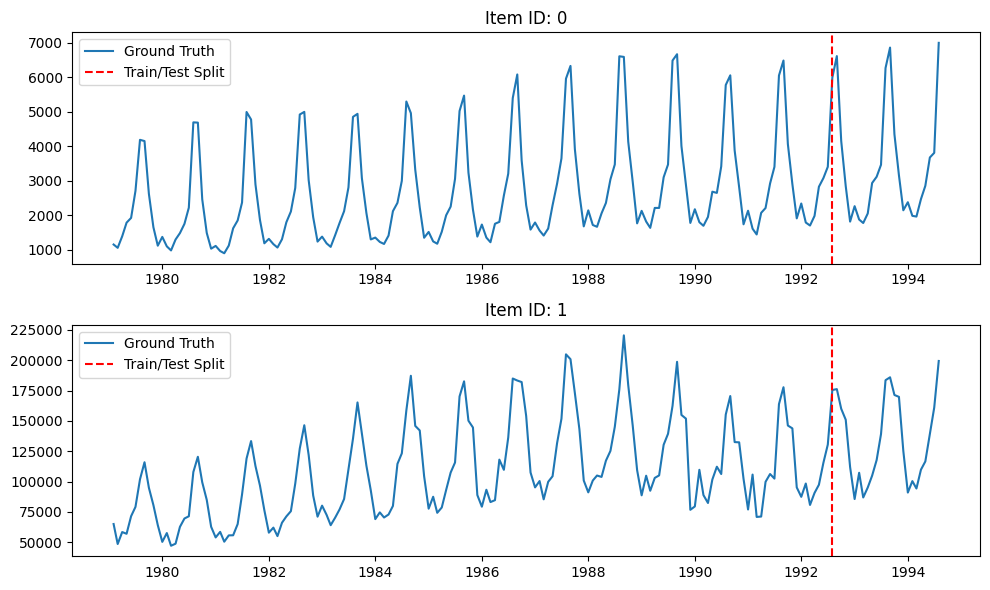

In [ ]:
plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

## **TabPFN-TS**

### Featurizing Time-Series Data for TabPFN

We have the following features implemented:


*   Running Index
*   Calendar Features (with sine and cosine transformations)



In [ ]:
import gluonts.time_feature

def add_running_index(df: pd.DataFrame) -> pd.Series:
    df['running_index'] = range(len(df))
    return df


def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    CALENDAR_COMPONENT = [
        "year",
        # "month",
        # "day",
    ]

    CALENDAR_FEATURES = [
        # (feature, natural seasonality)
        ("hour_of_day", 24),
        ("day_of_week", 7),
        ("day_of_month", 30.5),
        ("day_of_year", 365),
        ("week_of_year", 52),
        ("month_of_year", 12),
    ]

    timestamps = df.index.get_level_values("timestamp")

    for component_name in CALENDAR_COMPONENT:
        df[component_name] = getattr(timestamps, component_name)

    for feature_name, seasonality in CALENDAR_FEATURES:
        feature_func = getattr(gluonts.time_feature, f"{feature_name}_index")
        feature = feature_func(timestamps).astype(np.int32)
        if seasonality is not None:
            df[f"{feature_name}_sin"] = np.sin(2 * np.pi * feature / (seasonality - 1))   # seasonality - 1 because the value starts from 0
            df[f"{feature_name}_cos"] = np.cos(2 * np.pi * feature / (seasonality - 1))
        else:
            df[feature_name] = feature

    return df


We are now going to apply the feature extraction.

In [ ]:
# before feature extraction
train_tsdf.head()

target
item_id timestamp            
0       1979-01-31  1149.8700
        1979-02-28  1053.8002
        1979-03-31  1388.8798
        1979-04-30  1783.3702
        1979-05-31  1921.0252

In [ ]:
feature_selected = [
    add_running_index,
    add_calendar_features,
]

for f in feature_selected:
    train_tsdf = train_tsdf.groupby(level='item_id', group_keys=False).apply(f)
    test_tsdf = test_tsdf.groupby(level='item_id', group_keys=False).apply(f)

In [ ]:
# after feature extraction
train_tsdf.head()

target  running_index  year  hour_of_day_sin  \
item_id timestamp                                                     
0       1979-01-31  1149.8700              0  1979              0.0   
        1979-02-28  1053.8002              1  1979              0.0   
        1979-03-31  1388.8798              2  1979              0.0   
        1979-04-30  1783.3702              3  1979              0.0   
        1979-05-31  1921.0252              4  1979              0.0   

                    hour_of_day_cos  day_of_week_sin  day_of_week_cos  \
item_id timestamp                                                       
0       1979-01-31              1.0     8.660254e-01             -0.5   
        1979-02-28              1.0     8.660254e-01             -0.5   
        1979-03-31              1.0    -8.660254e-01              0.5   
        1979-04-30              1.0     0.000000e+00              1.0   
        1979-05-31              1.0     1.224647e-16             -1.0   

                    day_of_month_sin  day_of_month_cos  day_of_year_sin  \
item_id timestamp                                                         
0       1979-01-31          0.106293          0.994335         0.495009   
        1979-02-28         -0.507666          0.861554         0.842101   
        1979-03-31          0.106293          0.994335         0.999404   
        1979-04-30         -0.106293          0.994335         0.885456   
        1979-05-31          0.106293          0.994335         0.524704   

                    day_of_year_cos  week_of_year_sin  week_of_year_cos  \
item_id timestamp                                                         
0       1979-01-31         0.868888          0.473094          0.881012   
        1979-02-28         0.539320          0.833602          0.552365   
        1979-03-31         0.034516          0.995734          0.092268   
        1979-04-30        -0.464723          0.866025         -0.500000   
        1979-05-31        -0.851284          0.526432         -0.850217   

                    month_of_year_sin  month_of_year_cos  
item_id timestamp                                         
0       1979-01-31           0.000000           1.000000  
        1979-02-28           0.540641           0.841254  
        1979-03-31           0.909632           0.415415  
        1979-04-30           0.989821          -0.142315  
        1979-05-31           0.755750          -0.654861

### Prediction with TabPFN

Configure TabPFN

In [ ]:
from tabpfn_client import TabPFNRegressor

tabpfn = TabPFNRegressor(
    # model='model_cache/model_hans_regression_2noar4o2.ckpt',
)

In [ ]:

all_pred = []

# iteratively predict for each time series
for item_id in train_tsdf.item_ids:
    X_train, y_train = split_time_series_to_X_y(train_tsdf.loc[item_id])
    X_test, _ = split_time_series_to_X_y(test_tsdf.loc[item_id])

    tabpfn.fit(X_train, y_train)
    pred = tabpfn.predict_full(X_test)["median"]

    pred_tsdf = pd.DataFrame({
        "target": pred,
        "timestamp": test_tsdf.loc[item_id].index,
        "item_id": item_id,
    })
    all_pred.append(pred_tsdf)

all_pred = TimeSeriesDataFrame(pd.concat(all_pred))

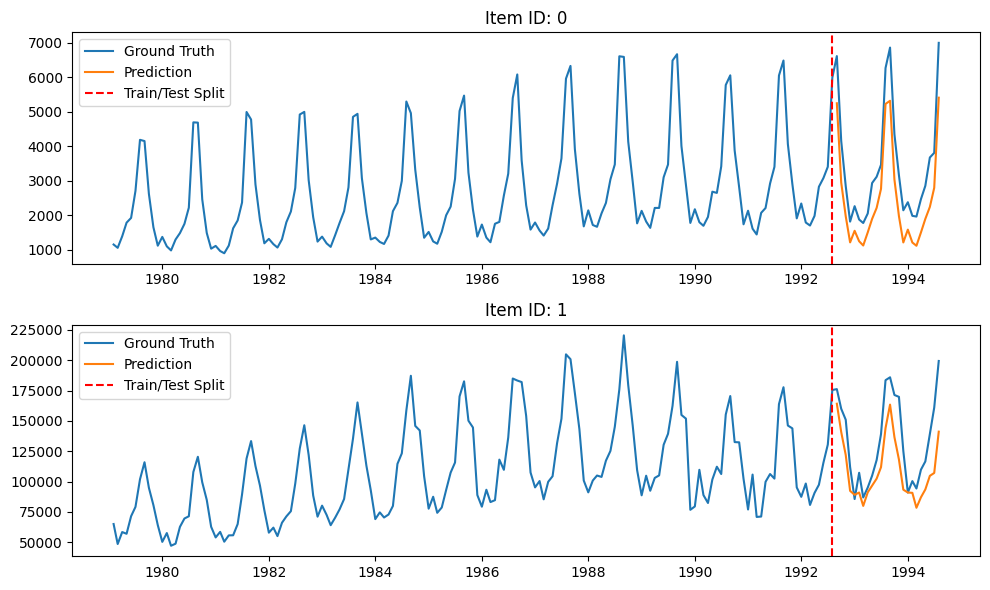

In [ ]:
plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=all_pred,
)